In [18]:
import pandas as pd

from pathlib import Path

import pandas as pd

from rdkit import Chem
from kinfraglib import utils

from rdkit.Chem import MACCSkeys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
HERE = Path(_dh[-1])
PATH_DATA = HERE / '../../data'

In [3]:
fragment_library_custom = utils.read_fragment_library(PATH_DATA / "fragment_library_custom_filtered")
fragment_library_custom.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1'])

In [4]:
def standardized_inchi(mol):
    return Chem.inchi.MolToInchiKey(utils.standardize_mol(mol))
    

In [5]:
standardized_mol_inchis = {sp: list(sp_lib['ROMol'].apply(standardized_inchi)) for sp, sp_lib in fragment_library_custom.items()}

In [6]:
standardized_mol_inchis['AP']

['HCTKTFWOSSBSIL-UHFFFAOYSA-N',
 'VSPXQZSDPSOPRO-UHFFFAOYSA-N',
 'AXWBJJJQRJBTMI-UHFFFAOYSA-N',
 'LDIJKUBTLZTFRG-UHFFFAOYSA-N',
 'MXVAGCQKBDMKPG-UHFFFAOYSA-N',
 'LRBDMVYIUGZSKX-UHFFFAOYSA-N',
 'FOQWCSIQBWFFOM-UHFFFAOYSA-N',
 'YNNMZEFRJKNDNH-UHFFFAOYSA-N',
 'JJTNLWSCFYERCK-UHFFFAOYSA-N',
 'JWVCLYRUEFBMGU-UHFFFAOYSA-N',
 'FWOPJXVQGMZKEP-UHFFFAOYSA-N',
 'MVXVYAKCVDQRLW-UHFFFAOYSA-N',
 'BMTSZVZQNMNPCT-UHFFFAOYSA-N',
 'LJXQPZWIHJMPQQ-UHFFFAOYSA-N',
 'KXDAEFPNCMNJSK-UHFFFAOYSA-N',
 'DCLWNTIANRACSB-UHFFFAOYSA-N',
 'PXDDCBOOHGDLBL-UHFFFAOYSA-N',
 'QMNUDYFKZYBWQX-UHFFFAOYSA-N',
 'DRYRBWIFRVMRPV-UHFFFAOYSA-N',
 'XPHWCAKVRKUXLK-UHFFFAOYSA-N',
 'NLCZMMKTARJHDH-UHFFFAOYSA-N',
 'YDTDKKULPWTHRV-UHFFFAOYSA-N',
 'HSKNBNNWHYJGMA-UHFFFAOYSA-N',
 'MBVAHHOKMIRXLP-UHFFFAOYSA-N',
 'RAIPHJJURHTUIC-UHFFFAOYSA-N',
 'GHPODDMCSOYWNE-UHFFFAOYSA-N',
 'FTNJQNQLEGKTGD-UHFFFAOYSA-N',
 'ISWSIDIOOBJBQZ-UHFFFAOYSA-N',
 'BAXOFTOLAUCFNW-UHFFFAOYSA-N',
 'BAXOFTOLAUCFNW-UHFFFAOYSA-N',
 'MFZQJIKENSPRSJ-UHFFFAOYSA-N',
 'ZYXBIO

In [7]:
# filter kinfraglib on stand. inchis
fragment_library = utils.read_fragment_library(PATH_DATA / "fragment_library")
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [8]:
for sp, sp_lib in fragment_library.items():
    sp_lib['standard_inchi'] = sp_lib['ROMol'].apply(standardized_inchi)

In [9]:
filtered_fragment_lib = {sp: fragment_library[sp][fragment_library[sp]['standard_inchi'].isin(inchis)] 
                         for sp, inchis in standardized_mol_inchis.items()}
filtered_fragment_lib.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1'])

In [10]:
special_names = {"DCLK1": "DCAMKL1"}

In [11]:
def scale_size(n, min_n, max_n, min_size, max_size):
    r_size = max_size - min_size
    r_n = max_n - min_n
    s = (n - min_n)/r_n
    return int(r_size * s + min_size)

In [12]:
def kinase_map_from_df(sp_lib, color):
    kinase_map = (sp_lib.groupby('kinase', as_index=False).size()
                    .rename(columns={'kinase': 'xName', 'size': 'num_fragments'}))

    kinase_map['xName'] = kinase_map['xName'].apply(lambda kinase : 
        special_names.get(kinase) or kinase.replace("-", "_"))

    kinase_map['shape'] = ['circle' for _ in range(len(kinase_map))]
    kinase_map['fill'] = [color for _ in range(len(kinase_map))]
    kinase_map['stroke'] = [color for _ in range(len(kinase_map))]
    kinase_map['strokeWidth'] = [color for _ in range(len(kinase_map))]
    kinase_map['fill'] = [color for _ in range(len(kinase_map))]
    
    return kinase_map

In [27]:
for sp, sp_lib_custom in filtered_fragment_lib.items():
    kinase_map = pd.concat([kinase_map_from_df(fragment_library[sp], "rgb(240,128,128)"), kinase_map_from_df(sp_lib_custom, "rgb(0,128,0)")])
    min_n, max_n = kinase_map['num_fragments'].min(), kinase_map['num_fragments'].max()
    kinase_map['size'] = kinase_map['num_fragments'].apply(lambda n: scale_size(n, min_n, max_n, 15, 50))
    kinase_map.to_csv(sp + "_kinase_map.csv", doublequote=False)

## Map remapped customKinFraglib to ligands:

In [14]:
custom_original_ligands = utils.get_original_ligands(pd.concat(filtered_fragment_lib.values()))

In [15]:
kfl_original_ligands = utils.get_original_ligands(pd.concat(fragment_library.values()))

In [22]:
import numpy as np
# copied from 2_3_... notebook:
def calc_tsne(original_maccs, custom_maccs): 
    """
TODO
    """
    # !!! custom is a subset of original, thus, we only need to fit on original
    # calculate MACCS fingerprints for t-sne 
    pca = PCA(n_components=50)
    crds = pca.fit_transform(list(original_maccs))
    crds_custom = pca.transform(list(custom_maccs))
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=0)
    crds_embedded = tsne.fit_transform(np.concatenate([crds, crds_custom], axis=0))
    # crds_embedded_custom = tsne.transform(crds_custom)

    return pd.DataFrame(crds_embedded[:len(original_maccs)], columns=["X", "Y"]), pd.DataFrame(crds_embedded[len(original_maccs):], columns=["X", "Y"])

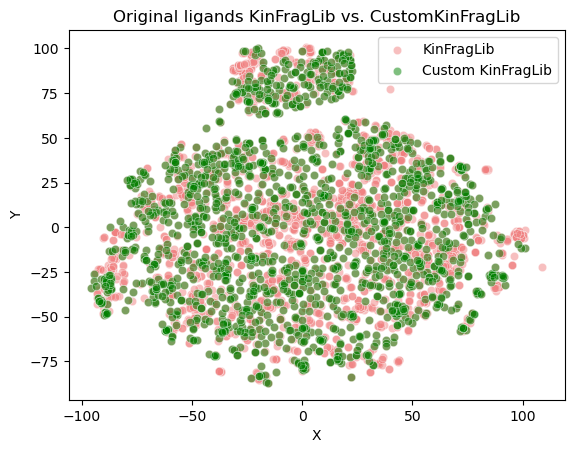

In [ ]:
# also adapted from this notebook
kfl_tsne_df, custom_kfl_tsne_df = calc_tsne(kfl_original_ligands['ROMol'].apply(MACCSkeys.GenMACCSKeys), custom_original_ligands['ROMol'].apply(MACCSkeys.GenMACCSKeys))

sns.scatterplot(
    data=kfl_tsne_df,
    x="X",
    y="Y",
    color='lightcoral',
    alpha=0.5,
    label="KinFragLib"
).set_title("Original ligands KinFragLib vs. CustomKinFragLib")
sns.scatterplot(
    data=custom_kfl_tsne_df,
    x="X",
    y="Y",
    color='green',
    alpha=0.5,
    label="Custom KinFragLib"
)

plt.legend()
plt.savefig(f"figures/tsne_original_lignads.pdf", dpi=300, bbox_inches="tight")
plt.show()